# Midterm

00:01 a.m. ~ 11:59 p.m. on Oct. 21st, 2021

### Instructions

**Before you turn this exam in, make sure everything runs as expected: in the menubar, select `Kernel` $\rightarrow$ `Restart & Run All`. If you have failing tests, then you may need to use `Cell` $\rightarrow$ `Run All Below` to execute cells past the failing tests. After running all (functional) cells in order you should leave the output in the notebook and submit.**

Any `assert` statements are provided to check your answers. Unlike skill checks, you may receive partial (or full) credit even if these code blocks fail, and you may not receive full credit even if they pass (e.g. if you hack them to pass). Problems without `assert` statements may have multiple correct solutions, and will be manually graded by instructors.

Make sure you fill in any place that says `YOUR CODE HERE`. Please also your name and official GT ID below.

In [1]:
NAME = ""
GTID = "" #e.g. gburdell0

## Logistical Notes and Instructions

Failure to follow these instructions may negatively impact your grade.

* **HonorLock should be enabled at this point**, and the HonorLock timer should currently be running. Accessing the exam without HonorLock enabled will be considered an honor code violation.

* Your exam must be submitted prior to the timer ending on your Canvas quiz. **Accessing the Vocareum assignment after the timer expires or downloading the exam file without permission will be considered an honor code violation.** Vocareum logs record all access times and downloads.

* You have **90 minutes to complete the exam**, and you have 15 extra minutes to deal with any logistical issues that may arise (105 minutes on the HonorLock quiz, 90 minutes on the Vocareum timer). If you encounter unexpected technical issues please notify instructors immediately to establish a contingency plan.

* If you have issues or questions please contact instructors via a **private Canvas message**. Do not use any other means of communication during the exam. Instructors will monitor Canvas closely during the "office hours" (11am-12pm, 2-3pm, and 5-6pm EST) and as often as possible in between. It is strongly recommended that you begin the exam during one of these windows. 

* Instructors will **not answer questions related to content** in order to ensure a fair experience for everyone. In the case of ambiguities, typos, or possible errors you will be asked to use your best judgement, so **please restrict questions to technical issues that hinder your ability to complete the exam.**

* You may use any online resources or your own notes on the exam. However, you may not communicate with any of your classmates regarding the exam at any point during the exam time window. **Inappropriate communication will be considered an honor code violation.**

* Code blocks containing `assert` statements should not cause errors if the solution is correct, but you may submit the notebook for partial credit even if they raise errors.

* There are 3 main problems, each with 2-3 sub-problems, that are worth a total of 130 points. Students in the 4745 section will receive 15 bonus points on the exam, but their total score cannot exceed 100%.

* Submit your exam through Vocareum when you are finished. You may push the submit button up to 20 times, so if you are feeling anxious you can submit at multiple points in the exam. Naturally, only the last submission will be graded.

## Problem 1: Numerical Methods (50 points)

### Loading data

The following block of code reads in data for the IR spectra of dichloromethane, selects the region between 1240 - 1300 cm$^{-1}$ and visualizes the data with a plot. You will work with this data throughout Problem 1.

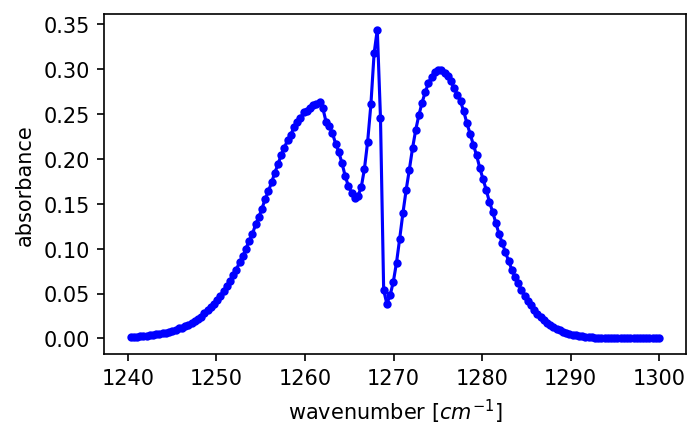

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('dichloromethane.csv')
x_all = df['wavenumber [cm^-1]'].values
y_all = df['intensity [a.u.]'].values

idxs = np.logical_and(x_all > 1240, x_all < 1300)
x_peak = x_all[idxs]
y_peak = y_all[idxs]

fig, ax = plt.subplots(figsize = (5, 3), dpi = 150)
ax.plot(x_peak, y_peak, '-b', marker = '.')
ax.set_xlabel('wavenumber [$cm^{-1}$]')
ax.set_ylabel('absorbance');

### 1a: Gaussian features (10 points)

You will create a set of evenly-spaced Gaussians which will be used as features in the next step. First, write a function `gaussian_features` that generates `N` evenly-spaced Gaussians with a fixed width `sigma` in a given range of `x`. The return value `features` should be an array (or matrix) with dimensions of (length of `x` X `N`).

In [3]:
def gaussian_features(x, N, sigma):
########################################

# YOUR CODE HERE
    features = np.zeros((len(x), N))
    x_mean = np.linspace(x.min(), x.max(), N)
    
    for i, mean in enumerate(x_mean):
        features[:, i] = np.exp( -(x - mean)**2 / 2 / sigma**2 )
########################################
    return features

Use `gaussian_features` to plot 10 evenly-spaced Gaussians from 1240 to 1300 with resolution of 100 (e.g. `len(x)=100`) and a width of 5 (e.g. `sigma=5`).

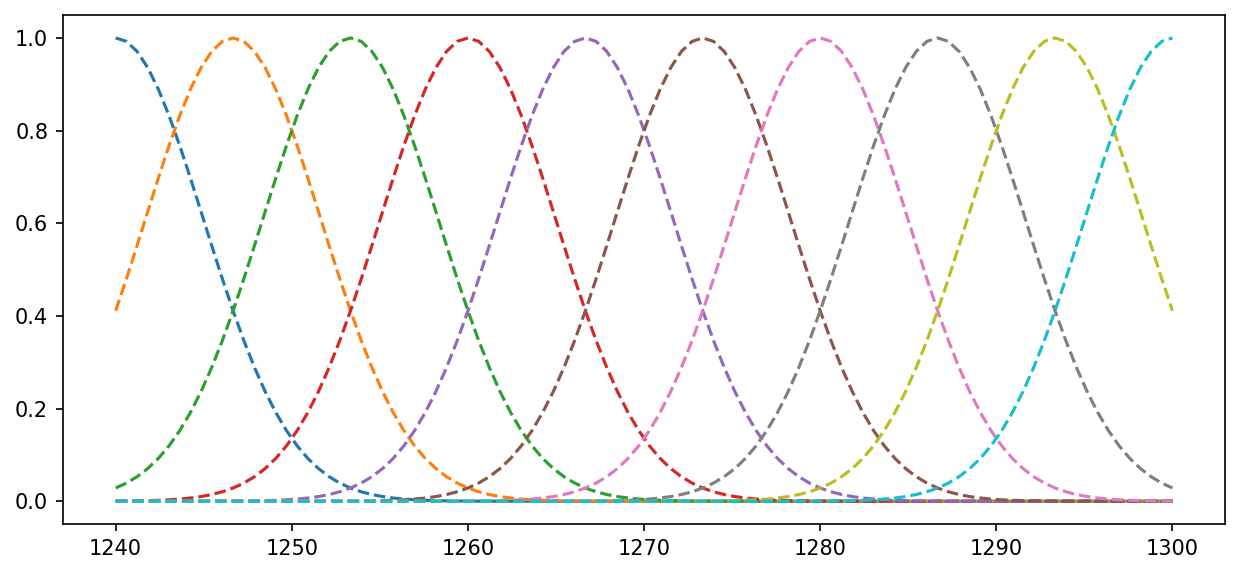

In [4]:
features = gaussian_features(np.linspace(1240, 1300, 100), 10, 5)
fig, ax = plt.subplots(figsize = (10, 4.5), dpi = 150)
ax.plot(np.linspace(1240, 1300, 100), features, '--');

### 1b: Gaussian linear regression (15 points)

You want to fit `y_peak` with these 10 newly created Gaussian features. Using general linear regression (including an intercept column) with the new features, plot the result of regression along with the original `y_peak`.

Print the coefficients of the model and plot the original data compared to the model.

**Hint:** You will need to re-generate the features using `x_peak` as the input so that you have the correct number of rows in your feature matrix.

**To receive full credit you should do this with only linear algebra. However, you will receive partial credit if you use scikit-learn or other built-in functions**

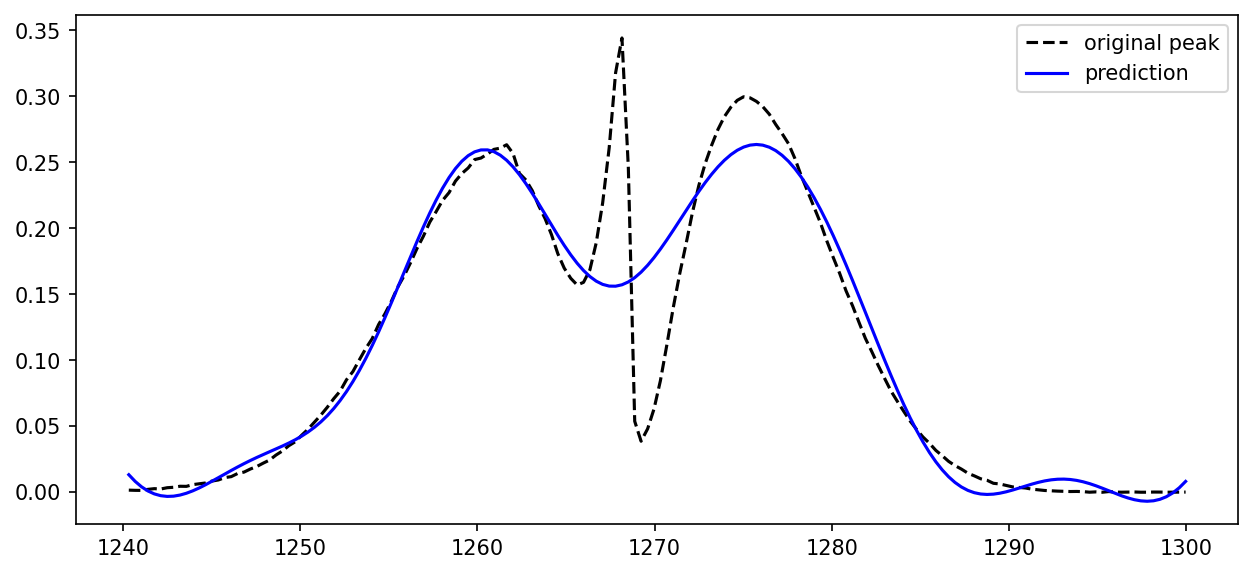

In [5]:
features = gaussian_features(x_peak, 10, 5)
intercept = np.ones((features.shape[0], 1))

features_w_int = np.append(intercept, features, axis = 1)

A = features_w_int.T@features_w_int
b = features_w_int.T@y_peak

w = np.linalg.solve(A, b)

fig, ax = plt.subplots(figsize = (10, 4.5), dpi = 150)
ax.plot(x_peak, y_peak, '--k', label = 'original peak')
ax.plot(x_peak, features_w_int@w, '-b', label = 'prediction')
ax.legend();

### 1c: Non-linear regression with Gaussians (20 points)

You will now perform non-linear regression by taking advantage of the `minimize` function from the `scipy` package. The problem is broken down into several sub-parts with auto-grader tests to help you check your work along the way.

First, we need to set up a "loss function" for non-linear regression. The function `loss` defined below takes the following arguments:

- a parameter vector `lamda` $\vec{\lambda} = [\vec{w}, \vec{\mu}, \vec{\sigma}]$ (1-dimensional numpy array)
- a training data `X` (wavenumbers in this case) (1-dimensional numpy array)
- a target values `y` (absorbance in this case) (1-dimensional numpy array)
- a number of Gaussians `N` (int)

Use this loss function to calculate the loss for an initial guess of three Gaussian peaks for the dataset provided:

- Peak 1: max height=0.25, location = 1260 cm$^{-1}$, width = 5 cm$^{-1}$
- Peak 2: max height=0.35, location = 1265 cm$^{-1}$, width = 1 cm$^{-1}$
- Peak 3: max height=0.25, location = 1275 cm$^{-1}$, width = 5 cm$^{-1}$

Store the resulting loss as `initial_loss`.

In [6]:
def loss(lamda, X, y, N):
    predict = np.zeros(X.shape[0])
    for i in range(N):
        predict += lamda[i] * np.exp(-(X - lamda[i+N])**2 / 2 / lamda[i+2*N]**2)
        
    return ((predict-y)**2).mean()

In [7]:
w = [0.25, 0.35, 0.25, 1260, 1265, 1275, 5, 1, 5]
initial_loss = loss(w, x_peak, y_peak, 3)

In [8]:
assert np.isclose(initial_loss, 0.00507463793), "Loss function not evaluated correctly"

The `minimize` function requires a loss function of which only one argument is unknown. Write a function `g` that takes the same argument as `loss` does, while `X`, `y`, and `N` are predefined and only `lamda` remains unknown. The returned value of `g` should be the same as that of `loss` function. The default values for `X`, `y`, and `N` are the same as in the first part of the problem (`X` and `y` are the spectra data, and `N=3`). 

In [9]:
def g(lamda, X = x_peak, y = y_peak, N = 3):
    return loss(lamda, X, y, N)

In [10]:
L_test = [0.1, 0.2, 0.3, 1250, 1260, 1270, 5, 4, 3]
assert np.isclose(g(L_test), 0.009824022386566447), "function g not implemented correctly."

Minimize the `g` function with respect to `lamda` by using the scipy `minimize` function. You should use the `L-BFGS-B` algorithm for the optimization.  Save the result to a variable `result`.  The initial guess for `lamda` is provided below.

In [11]:
lamda_guess = [0.25, 0.35, 0.25, 1260, 1268, 1274, 5, 0.5, 5]

# YOUR CODE HERE
from scipy.optimize import minimize
result = minimize(g, lamda_guess, method = 'L-BFGS-B')

In [12]:
assert np.isclose(np.linalg.norm(result.x), 2196.5375587508233), "Result of minimization is not correct."

### 1d: Visualizing non-linear regression result (5 points)

Plot the result of the non-linear regression model compared to the actual data.

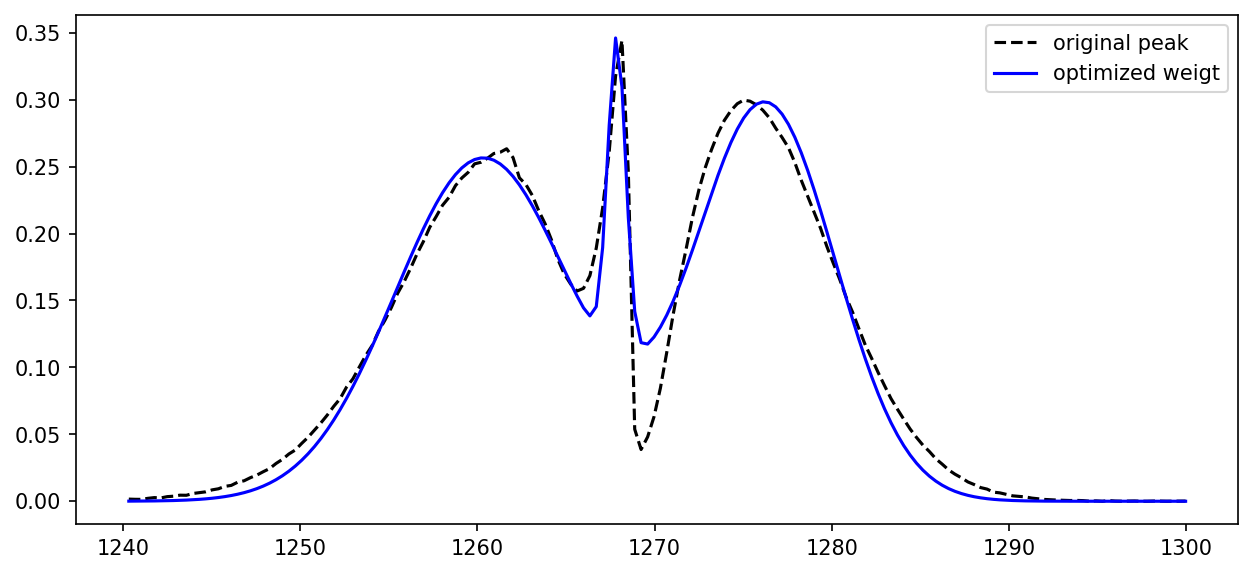

In [13]:

# YOUR CODE HERE
predict = np.zeros(x_peak.shape[0])
for i in range(3):
    predict += result.x[i] * np.exp(-(x_peak - result.x[i+3])**2 / 2 / result.x[i+2*3]**2)
    
fig, ax = plt.subplots(figsize = (10, 4.5), dpi = 150)
ax.plot(x_peak, y_peak, '--k', label = 'original peak')
ax.plot(x_peak, predict, '-b', label = 'optimized weigt')
ax.legend();

## Problem 2: Regression and Hyperparameter Tuning (35 points)

### 2a: Kernel Ridge Regression (15 points)

In this problem, you will make use of the `scikit-learn` kernel ridge regression model, and tune one hyperparameter (`alpha`) of the model using hold-out. The problem is broken into sub-parts with tests to help you along the way.

Reshape `x_peak` and `y_peak` into 166 x 1 2-D numpy array.

In [14]:

# YOUR CODE HERE
x_peak = x_peak.reshape(-1, 1)
y_peak = y_peak.reshape(-1, 1)

In [15]:
assert np.dot(x_peak, y_peak.T).shape == (166,166)

We have imported `KernelRidge` and `train_test_split` for you. Split `x_peak` and `y_peak` to `x_train`, `x_test`, `y_train`, and `y_test` using `train_test_split`. The `test_size` and `random_state` should be `0.25` and `12`, respectively. 

***Note***: If you fail to set a proper `random_state`, you won't pass any assertion tests for the following problems.

In [16]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split


# YOUR CODE HERE
x_train, x_test, y_train, y_test = train_test_split(x_peak, y_peak, test_size = .25, random_state = 12)

In [17]:
assert np.isclose(np.linalg.norm(x_train) * np.linalg.norm(y_test), 14327.319116271352), "Data split is not correct."

Next, you use the train/test split you just peformed to find the optimum `alpha` out of [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]. The following is the expected training steps for each `alpha`:

- Declare a `KernelRidge(kernel = 'rbf', gamma = 0.5)` model
- Train the model on the training set
- Find $\mathrm{r^2}$ on the test set

The optimum `alpha` is the one that gives you the highest $\mathrm{r^2}$ on the test set. Report the optimum as `opt_alpha` and the highest $\mathrm{r^2}$ as `opt_r2`.

In [18]:
alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]


# YOUR CODE HERE
opt_r2 = 0
for alpha in alphas:
    krr = KernelRidge(kernel = 'rbf', gamma = 0.5, alpha = alpha)
    krr.fit(x_train, y_train)
    
    if opt_r2 < krr.score(x_test, y_test):
        opt_r2 = krr.score(x_test, y_test)
        opt_alpha = alpha

In [19]:
assert np.isclose(opt_alpha*opt_r2/2., 0.004993788099684231)

### 2b: GridSearchCV (20 points)

In this problem you will optimize a kernel ridge regression model using GridSearchCV. The following are the requirements for full credit:

* You should use every second data point as a *validation* set (code for split is provided)
* You should test at least 5 different options for both `alpha` and `gamma` (5 pts).
* You should use 5-fold cross-validation to optimize the hyperparameters (5 pts).
* You should show that the optimal model achieves an r$^2$ score of at least 0.96 on the *validation* set (5 pts).
* You should include a plot that shows the training data as red points, validation data as blue points, and the model as a black line (5 pts).

In [20]:
from sklearn.model_selection import GridSearchCV

In [21]:
x_train = x_peak[::2]
y_train = y_peak[::2]
x_val = x_peak[1::2]
y_val = y_peak[1::2]


# YOUR CODE HERE
alphas = np.logspace(-6, -1, 6)
gammas = np.logspace(-5, -1, 5)

krr = KernelRidge(kernel = 'rbf')
param_grid = {'alpha': alphas, 'gamma': gammas}

gcv = GridSearchCV(krr, param_grid, cv = 5)
gcv.fit(x_train, y_train)

print(gcv.score(x_test, y_test))

0.9950506645559305


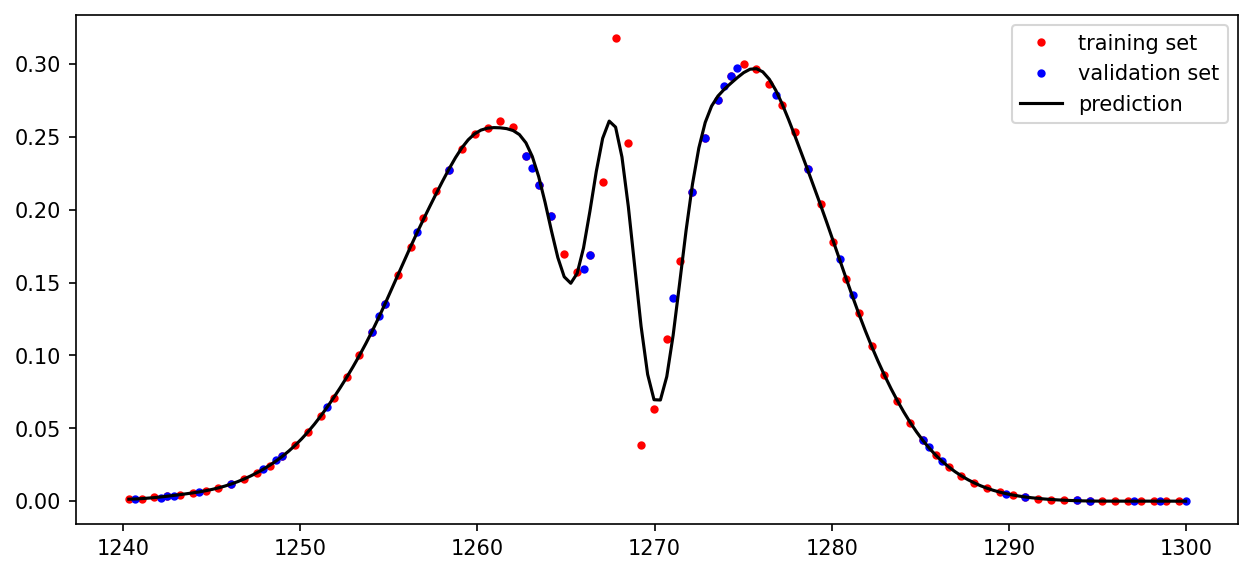

In [22]:
fig, ax = plt.subplots(figsize = (10, 4.5), dpi = 150)
ax.plot(x_train, y_train, 'r.', label = 'training set')
ax.plot(x_test, y_test, 'b.', label = 'validation set')
ax.plot(x_peak, gcv.best_estimator_.predict(x_peak), '-k', label = 'prediction')
ax.legend();

## Problem 3: Classification (45 points)

### 3a: Softmax Loss Function (20 points)

In this problem you will create a softmax loss function by hand. The softmax loss function discriminates between two different classes as follows:

$\bar{\bar{X}}\vec{w} > 0$ if $y_i = 1$ (class 1)

$\bar{\bar{X}}\vec{w} < 0$ if $y_i = -1$ (class -1)

Then, the softmax loss function calculates $\sum_{i} log(1 + exp(-y_i\bar{\bar{X}}\vec{w}))$.

You may want to use the `add_intercept` and `linear_classifier` functions defined below for this problem.

In [23]:
def add_intercept(X):
    intercept = np.ones((X.shape[0], 1))
    X_intercept = np.append(intercept, X, 1)
    return X_intercept

def linear_classifier(X, w):
    X_intercept = add_intercept(X)
    p = np.dot(X_intercept, w)
    return [1 if pi > 0 else -1 for pi in p]

In this problem, you will work with the perovskite dataset. For the perceptron loss function, you will work with the `t` and `tau` feautures, as defined in the `X` and `y` matrices below. The problem is broken into several parts with tests to help you along the way.

In [24]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('perovskite_data.csv')

X_perov = df[['t', 'tau']].values
y_perov = df['exp_label'].values

#### Implement the softmax loss function

Create a function `softmax_loss` that calculates the $\sum_{i} log(1 + exp(-y_i\bar{\bar{X}}\vec{w}))$. It should take the parameters as follows:

- w: parameter vector $\vec{w}$ (numpy.ndarray)
- X: feature matrix $\bar{\bar{X}}$ (numpy.ndarray, default value = `X_perov`)
- y: target classes $y_i$ (numpy.ndarray, default value = `y_perov`)

In [25]:
########################################
def softmax_loss(w, X = X_perov, y = y_perov):
    X_intercept = add_intercept(X)
    Xb = np.dot(X_intercept, w)
    exp_yXb = np.exp(-y * Xb)
    return sum(np.log(1 + exp_yXb))
########################################

In [26]:
w1 = [10, 4, -10]
assert np.isclose(softmax_loss(w1), 6164.109777934653), "Test run 1 failed"

w2 = [12, 4, -5]
assert np.isclose(softmax_loss(w2, X_perov, y_perov+1), 1751.3276128615648), "Test run 2 failed"

#### Train the softmax model

Find the optimal weight vector by using `scipy.optimize.minimize` function. You should use the `L-BFGS-B` algorithm for minimizing the softmax loss function, and all other settings of `minimize` should be the default. The resulting optimized weight vector should be named as `w_opt`. The initial weight vector `w_init` is given for you.

In [27]:
w_init = [-2, 1, 2]

########################################

# YOUR CODE HERE
res = minimize(softmax_loss, w_init, method = 'L-BFGS-B')
w_opt = res.x
########################################

In [28]:
assert np.isclose(np.linalg.norm(w_opt), 13.43486665411793)

#### Assess the softmax model

Report the accuracy, precision, and recall of your trained model as `accuracy`, `precision`, and `recall`, respectively. Positive refers to class 1 and negative refers to class -1. You may use built-in functions from `scikit-learn` or calculate the metrics manually.

In [29]:
########################################

# YOUR CODE HERE
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy = accuracy_score(y_perov, linear_classifier(X_perov, w_opt))
precision = precision_score(y_perov, linear_classifier(X_perov, w_opt))
recall = recall_score(y_perov, linear_classifier(X_perov, w_opt))
########################################

In [30]:
assert hash(accuracy) == 2113689425112552704, "Accuracy is incorrect"
assert hash(precision) == 2081566485521176576, "Precision is incorrect"
assert hash(recall) == 2187972440052610560, "Recall is incorrect"

### 3b: Visualizing the decision boundary (10 points)

Plot the data with colors determined by the *data labels* (not the predicted labels) and visualize the decision boundary line as a solid black line. Set the y-axis limits to be [0, 8].

**Hint:** Pay attention to which column is the intercept in your loss function! The equation you use will vary depending on whether you use the first or last column as the intercept.

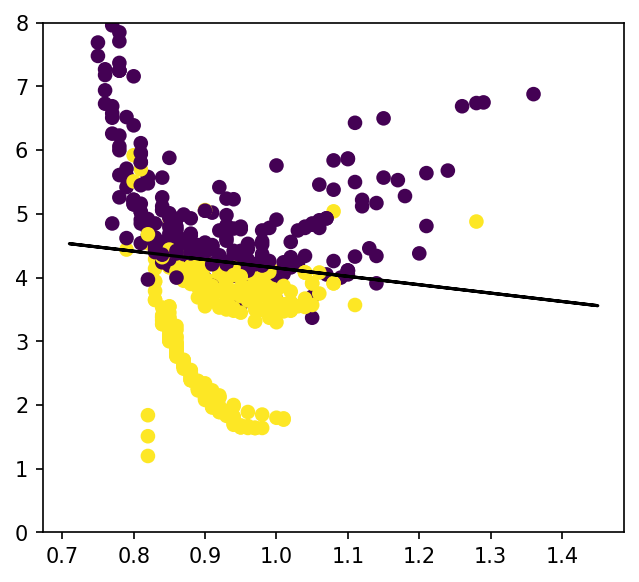

In [31]:

# YOUR CODE HERE
fig, ax = plt.subplots(figsize = (5, 4.5), dpi = 150)
ax.scatter(X_perov[:, 0], X_perov[:, 1], c = y_perov)

m = -w_opt[1] / w_opt[2]
b = -w_opt[0] / w_opt[2]
ax.plot(X_perov[:, 0], m*X_perov[:, 0] + b, 'k-')

ax.set_ylim([0, 8]);

### 3c: Maximizing accuracy (15 points)

Using a classification algorithm of your choice, construct and optimize a classification model. The following are the requirements for full credit:

* You should use the *validation* set defined below to evaluate the accuracy.
* You should only use the features defined below.
* You should optimize at least one hyperparameter by checking at least 5 different values and print the optimal hyperparameter(s) (5 pts)
* You should show that the optimal model achieves accuracy, precision, and recall of $>$90% (each one should be $>$90%) on the *validation* set (5 pts).
* You should plot the confusion matrix for the *validation set* (5 pts)

In [32]:
from sklearn.model_selection import train_test_split

X_perov = df[['rA (Ang)', 'rB (Ang)', 'rX (Ang)']].values
y_perov = df['exp_label'].values

X_train, X_val, y_train, y_val = train_test_split(X_perov, y_perov, test_size = .5, random_state = 1017)

In [33]:

# YOUR CODE HERE
from sklearn.tree import DecisionTreeClassifier

depths = range(2, 11)

opt_acc = 0
for depth in depths:
    dtree = DecisionTreeClassifier(max_depth = depth)
    dtree.fit(X_train, y_train)

    if opt_acc < dtree.score(X_val, y_val):
        opt_depth = depth
        opt_acc = dtree.score(X_val, y_val)

In [34]:

# YOUR CODE HERE
dtree = DecisionTreeClassifier(max_depth = opt_depth)
dtree.fit(X_train, y_train)

acc = accuracy_score(y_val, dtree.predict(X_val))
prec = precision_score(y_val, dtree.predict(X_val))
rec = recall_score(y_val, dtree.predict(X_val))

print(acc, prec, rec)

0.9097222222222222 0.93125 0.9085365853658537


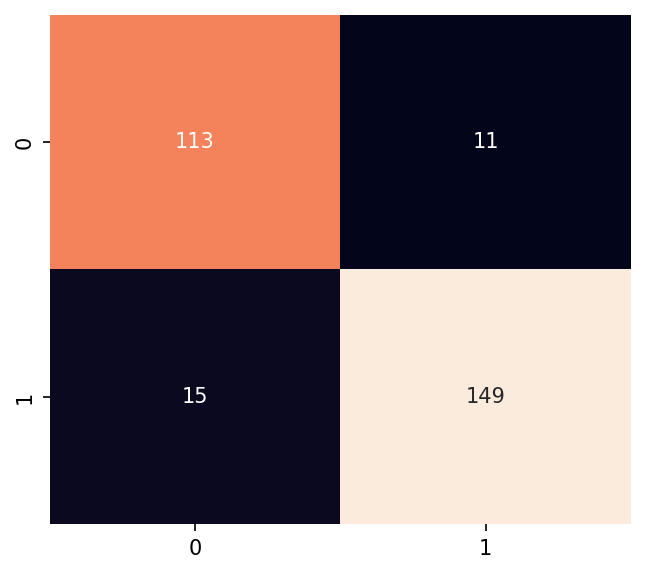

In [35]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, dtree.predict(X_val))

import seaborn as sns

fig, ax = plt.subplots(figsize = (5, 4.5), dpi = 150)
sns.heatmap(cm, ax = ax, annot = True, fmt = "d", cbar = False);